In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import networkx as nx
import sys
sys.path.insert(0, 'utils/')
from GR_Maze_Utils import *
from GR_RL_Utils import *

from matplotlib import rc
rc('text', usetex=True)

%load_ext autoreload
%autoreload 2

In [2]:
def create_binary_tree_directed(levels):
    G = nx.DiGraph()
    G.add_nodes_from([('r')])
    #index = 0
    for l in range(1,levels+1):
        for i in range(2**l):
            bin_i = bin(i)[2:].zfill(l)
            G.add_nodes_from([('r'+ bin_i[::-1])])
    edges = []
                    
    edges += [('r','r0')]
    edges += [('r','r1')]
    
    for i in list(G.nodes):
        for j in list(G.nodes):
            if len(i) == len(j)+1 and j == i[:len(j)] and (i,j) not in edges and (j,i) not in edges:
                edges += [(i,j)]
    G = add_diedges_to_graph(G,edges)
    return G

def get_transition_matrix(levels): 
    G = create_binary_tree_directed(levels)
    index_to_state = get_index_to_state_vec(G)
    S = len(index_to_state)
    A = 3 #a= 0, go down left branch, a = 1, go down right branch, a = 2 go up the tree. 
    Tmat = np.zeros((S,A,S)) + 1e-6 #add small constant to avoid dividing by zero downstream. 
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        for a in range(A):
            if len(n2) == levels + 1 and a < 2: #at the leaf, turn back regardless
                n3 = n2[:-1]
            elif len(n2) == 1 and a == 2: 
                n3 = n2 + str(1-int(n1[-1]))#at the root, there's no going back up further go from 'r' to 'r1' or 'r' to 'r0' 
                                            #depending on whether you come from 'r0' or 'r1' resp. 
            else:
                if a == 2: #go up the tree
                    n3 = n2[:-1]
                else: #go left or right
                    n3 = n2 + str(a)
                    
            nextstate = (n2,n3)
            nextstate_index = get_state_index(nextstate,G)
            Tmat[s,a,nextstate_index] = 1
            
    Tmat /= np.sum(Tmat,axis=-1)[:,:,None]
    return Tmat

### Get the number of direct paths when the agent is unrewarded. This is to measure the rate of taking a direct path when the agent explores using the exploration statistics employed by the unrewarded mice. 

In [4]:
np.random.seed(0)

# Learning parameters
alpha = 0 
gam = 0
starts = [('r','r0'),('r','r1')]
goal = ('r10010','r100101')
rew = 0
niter = 5000
nepi = 100
renewtime = 60
lamb = 0.0 
mode = 2

nruns = 20
tmax = 7000

clrs = []

for i in range(nruns):
    G = create_binary_tree_directed(6)
    Tmat = get_transition_matrix(6)
    S = Tmat.shape[0]
    index_to_state = get_index_to_state_vec(G)
    
    #Exploration values obtained from applying MaxEnt IRL on unrewarded mice data
    Qe_mice = np.load("unrew_mice_Qvalues.npy")
    for s in range(S):
        state = index_to_state[s]
        G[state[0]][state[1]]['Qe'] = Qe_mice[s]
        G[state[0]][state[1]]['Qr'] = np.zeros(3)
        
    nodes,time_rews,cum_rews,Gs = run_RL_simulation(G,Tmat,starts, goal, nepi,niter,renewtime,lamb = lamb,\
                                    renew = False,alpha = alpha,gam=gam,rew= rew,mode=mode)

    thresh_run  = 7
    goal_node = 'r100101'

    runl_goal,times_goal = get_run_lengths_to_goal(nodes,[goal_node])
    cuml_lr,timl_lr = process_run_lengths(runl_goal,times_goal,thresh_run)

    ti = np.argmin(np.abs(np.array(timl_lr) - tmax))
    clr = cuml_lr[ti]
    clrs += [clr*tmax/timl_lr[ti]]
    print(clrs[-1])

13.08411214953271
12.47216035634744
7.644007644007644
3.7593984962406015
4.9184935356942105
4.005149477900157
12.91696238466998
7.7134986225895315
8.742714404662781
1.932367149758454
6.147540983606557
9.505129752564876
11.538461538461538
9.585102012871422
5.04759157773291
20.41113864994897
15.142774733198731
9.09484625378952
11.23431572804202
7.207413339434847


In [5]:
#compute mean and std of no. of direct paths in tmax
mean_ctrl = np.mean(clrs)
std_ctrl = np.std(clrs)
print(mean_ctrl, std_ctrl)

9.105158939552744 4.320888196937565


## Plot learning curves (used in Figure 1 and Figure S2)

### Note: the visualization of the learning curves for the three nodes is not presented in the paper. 

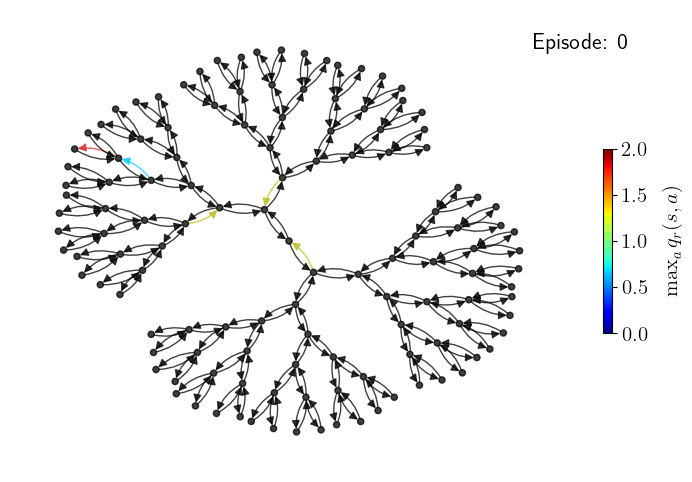

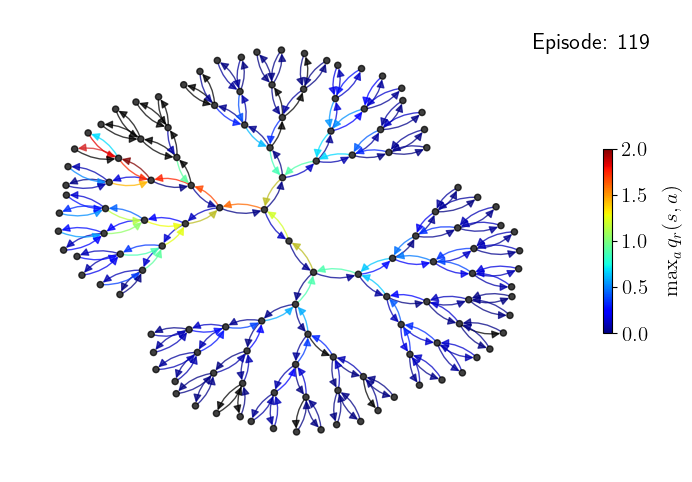

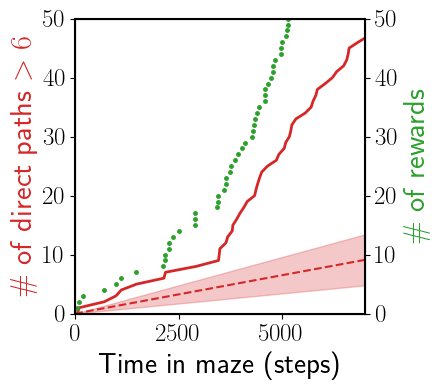

In [6]:
seed = 6 #example shown in paper. In Figure S2, the learning curves for seeds 0 to 9 are plotted. 
np.random.seed(seed)

# Learning parameters
alpha = 0.33 #learning rate.
gam = 0.99 #discount factor.
starts = [('r','r0'),('r','r1')]
goal = ('r10010','r100101')
rew = 2 #2
niter = 5000
nepi = 120
renewtime = 60
lamb = 0.0 #0.0

mode = 2 #expected SARSA

G = create_binary_tree_directed(6)
Tmat = get_transition_matrix(6)
S = Tmat.shape[0]
index_to_state = get_index_to_state_vec(G)

Qe_mice = np.load("unrew_mice_Qvalues.npy")
for s in range(S):
    state = index_to_state[s]
    G[state[0]][state[1]]['Qe'] = Qe_mice[s]
    G[state[0]][state[1]]['Qr'] = np.zeros(3)

nodes,time_rews,cum_rews,Gs = run_RL_simulation(G,Tmat,starts, goal, nepi,niter,renewtime,lamb = lamb,\
                                renew = False,alpha = alpha,gam=gam,rew= rew,mode=mode)

L = 7
show= [('r0','r'),('r11','r1'),('r101','r10')]
plot_graph_Qr(Gs[0], episode = 0, vmax = rew, goals = [goal], figsize = (9,6),show = show)
plot_graph_Qr(Gs[-1], episode = len(Gs)-1, vmax = rew, goals = [goal], figsize = (9,6),show = show)

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))

#Long runs to goal
runl_goal,times_goal = get_run_lengths_to_goal(nodes,[goal_node])
cuml_lr,timl_lr = process_run_lengths(runl_goal,times_goal,thresh_run)
axis.plot(timl_lr,cuml_lr,'C3-',lw=2)

axis.fill_between([0,tmax],[0,mean_ctrl-std_ctrl],[0,mean_ctrl+std_ctrl],color = 'C3',alpha = 0.25)
axis.plot([0,tmax],[0,mean_ctrl],'C3--')


#Uncomment this to visualize learning curves for direct paths from specific nodes
# passing = ['r11','r0','r101']
# colors = ['C2','C1','C8']
# for pn,co in zip(passing,colors):
#     lengths, times = get_run_lengths_to_goal(nodes,[goal[1]],passing_nodes = pn)
#     filt = (lengths > L-1)
#     timl_pn = times[filt]
#     cuml_pn = np.arange(len(timl_pn))
#     axis.plot(timl_pn,cuml_pn,co + '-',lw=2)

ax = axis.twinx()    
ax.plot(time_rews,cum_rews,'C2.',ms=5)

rmax = 50
tmax = 7000
axis.set_xlim(0,tmax)
axis.set_ylim(0,rmax)
axis.tick_params(labelsize = 18)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.5)
#axis.legend(fontsize = 15, frameon=False)
axis.set_xlabel("Time in maze (steps)",fontsize = 21)
axis.set_ylabel(r"\# of direct paths $> 6$",fontsize = 22, color = 'C3')
#axis.set_yticks([])
ax.set_ylim(0,rmax)
ax.tick_params(labelsize = 18)
ax.set_ylabel(r"\# of rewards",fontsize = 22, color = 'C2')

fig.tight_layout()
plt.show()

#### Output images to create movie

/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb  = fig.colorbar(mapper, shrink = 0.4)
/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb  = fig.colorbar(mapper, shrink = 0.4)
/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will rai

/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb  = fig.colorbar(mapper, shrink = 0.4)
/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb  = fig.colorbar(mapper, shrink = 0.4)
/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will rai

/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb  = fig.colorbar(mapper, shrink = 0.4)
/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb  = fig.colorbar(mapper, shrink = 0.4)
/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will rai

/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb  = fig.colorbar(mapper, shrink = 0.4)
/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb  = fig.colorbar(mapper, shrink = 0.4)
/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will rai

/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb  = fig.colorbar(mapper, shrink = 0.4)
/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb  = fig.colorbar(mapper, shrink = 0.4)
/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will rai

/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb  = fig.colorbar(mapper, shrink = 0.4)
/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb  = fig.colorbar(mapper, shrink = 0.4)
/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_98285/2444850355.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will rai

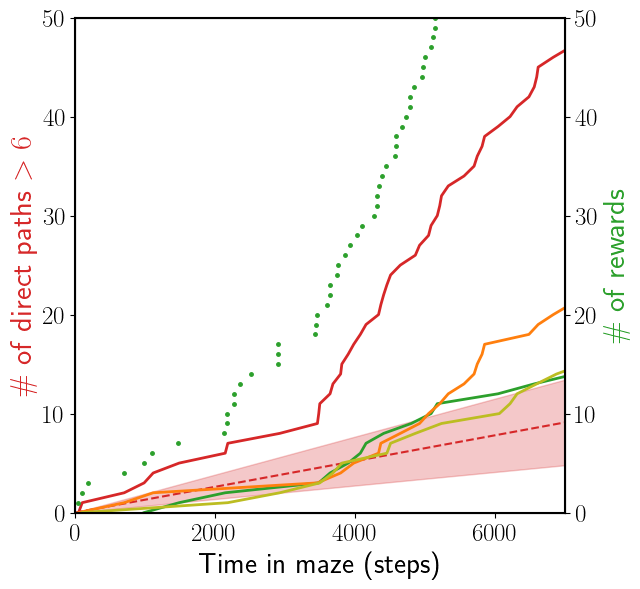

In [7]:
L = 7
name_prefix = "movie_exp_maze_s%d/movie"%seed
show= [('r0','r'),('r11','r1'),('r101','r10')]


for i in range(len(Gs[:])):
    G = Gs[i]
    plt.close("all")
    fig,axis = plt.subplots(1,1,figsize = (9,6))
    goals = [goal]
    norm = matplotlib.colors.Normalize(vmin=0, vmax=rew, clip=True)
    cmap = cm.jet
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    cs_e =[]
    for l in list(G.edges):
        v = np.max(G[l[0]][l[1]]['Qr'])
        if v < 1e-3:
            cs_e += [(0,0,0,0.1)]
        else:
            cs_e += [mapper.to_rgba(v)]
                    
    if goals is not None:
        for goal in goals:
            for k,n in enumerate(list(G.edges)):
                if n[0] == goal[0] and n[1] == goal[1]:
                    cs_e[k] =  matplotlib.colors.to_rgba("C3")

    colors = ['C1','C2','C8']
    if show is not None:
        for si,s in enumerate(show):
            for k,n in enumerate(list(G.edges)):
                if n[0] == s[0] and n[1] == s[1]:
                    cs_e[k] = matplotlib.colors.to_rgba(colors[si])    

                    
    im = nx.draw_kamada_kawai(G, connectionstyle='arc3, rad = 0.2', ax = axis, edge_color = cs_e, arrowsize = 12, node_size = 20, node_color = 'k', alpha = 0.75)
    episode = i + 1
    axis.text(1,1,"Episode: "  + "{0:4d}".format(episode), fontsize = 16, fontfamily = "sans-serif")
    mapper._A = []
    cb  = fig.colorbar(mapper, shrink = 0.4)
    cb.set_label(r"$\max_a q_r(s,a)$", fontsize = 15, labelpad = 10)
    cb.ax.tick_params(labelsize = 15)
    
    save_name = "./movies/" + name_prefix + "_graph_%04d.png"%i
    if save_name is not None:
        fig.savefig(save_name, dpi = 100)
    else:
        plt.show()
    
    plt.close("all")
    fig,axis = plt.subplots(1,1,figsize = (6.5,6))

    #Long runs to goal
    runl_goal,times_goal = get_run_lengths_to_goal(nodes,[goal_node])
    cuml_lr,timl_lr = process_run_lengths(runl_goal,times_goal,thresh_run)
    axis.plot(timl_lr[:i],cuml_lr[:i],'C3-',lw=2)

    axis.fill_between([0,tmax],[0,mean_ctrl-std_ctrl],[0,mean_ctrl+std_ctrl],color = 'C3',alpha = 0.25)
    axis.plot([0,tmax],[0,mean_ctrl],'C3--')
    
    passing = ['r11','r0','r101']
    colors = ['C2','C1','C8']
    for pn,co in zip(passing,colors):
        lengths, times = get_run_lengths_to_goal(nodes,[goal[1]],passing_nodes = pn)
        filt = (lengths > L-1)*(times < time_rews[i])
        timl_pn = times[filt]
        cuml_pn = np.arange(len(timl_pn))
        axis.plot(timl_pn,cuml_pn,co + '-',lw=2)
    ax = axis.twinx()    
    ax.plot(time_rews[:i],cum_rews[:i],'C2.',ms=5)

    rmax = 50
    tmax = 7000
    axis.set_xlim(0,tmax)
    axis.set_ylim(0,rmax)
    axis.tick_params(labelsize = 18)
    for sp in ['top','bottom','left','right']:
        axis.spines[sp].set_linewidth(1.5)
    #axis.legend(fontsize = 15, frameon=False)
    axis.set_xlabel("Time in maze (steps)",fontsize = 21)
    axis.set_ylabel(r"\# of direct paths $> 6$",fontsize = 22, color = 'C3')
    #axis.set_yticks([])
    ax.set_ylim(0,rmax)
    ax.tick_params(labelsize = 18)
    ax.set_ylabel(r"\# of rewards",fontsize = 22, color = 'C2')

    fig.tight_layout()
    fig.savefig("./movies/" + name_prefix + "_curve_%04d.png"%(i), dpi = 100)
    #plt.show()

In [11]:
#To generate movies, use ffmpeg commands below in the terminal within the folder where the output images are stored. 

#ffmpeg -framerate 15 -pattern_type glob -i 'movie_curve_*.png' -c:v h264 -pix_fmt yuv420p -allow_sw 1 -vb 20M curve.mp4
#ffmpeg -framerate 15 -pattern_type glob -i 'movie_graph_*.png' -c:v h264 -pix_fmt yuv420p -vb 20M graph.mp4
#ffmpeg -i graph.mp4 -i curve.mp4 -filter_complex hstack=inputs=2 -vb 20M final.mp4

### Run simulations using SARSA(0) for ten seeds

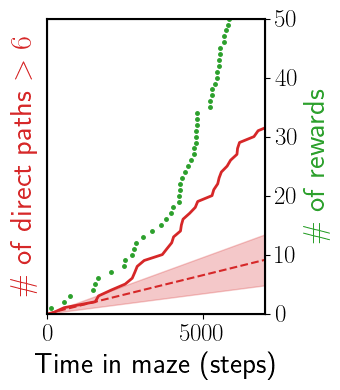

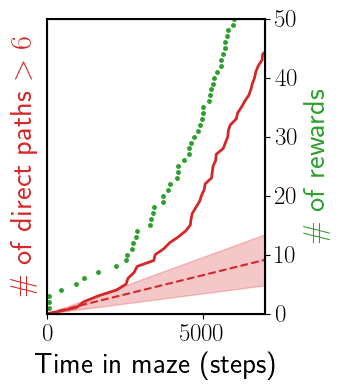

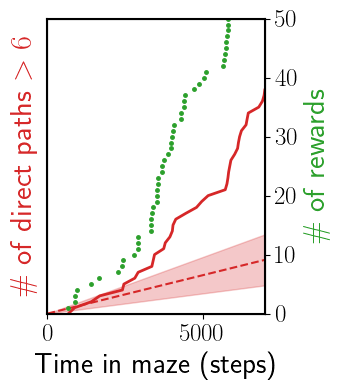

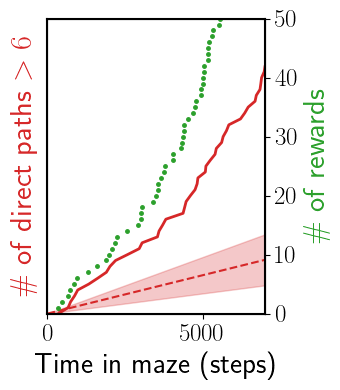

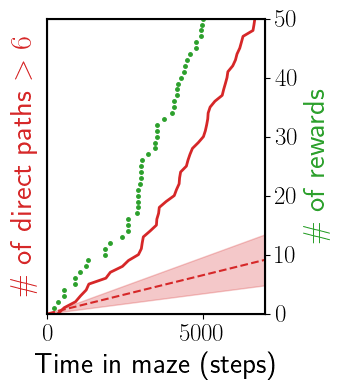

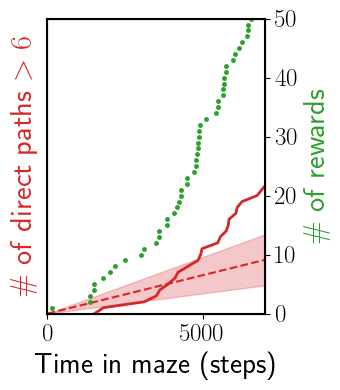

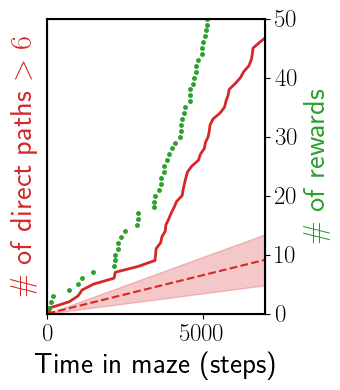

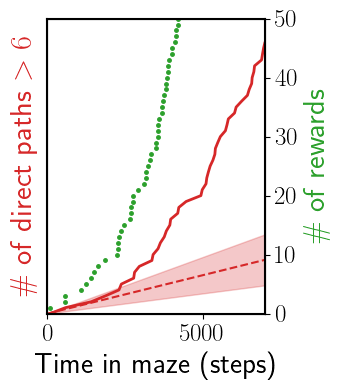

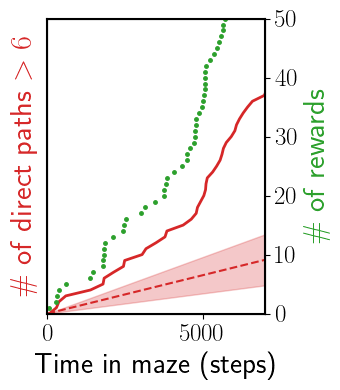

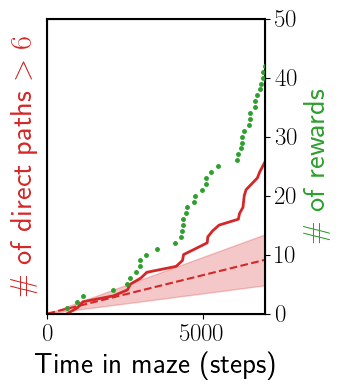

In [28]:
for s in range(10):
    np.random.seed(s)
    
    # Learning parameters
    alpha = 0.33 #learning rate.
    gam = 0.99 #discount factor.
    starts = [('r','r0'),('r','r1')]
    goal = ('r10010','r100101')
    rew = 2 #2
    niter = 5000
    nepi = 120
    renewtime = 60
    lamb = 0.0 #0.0

    mode = 2 #expected SARSA

    G = create_binary_tree_directed(6)
    Tmat = get_transition_matrix(6)
    S = Tmat.shape[0]
    index_to_state = get_index_to_state_vec(G)

    Qe_mice = np.load("unrew_mice_Qvalues.npy")
    for s in range(S):
        state = index_to_state[s]
        G[state[0]][state[1]]['Qe'] = Qe_mice[s]
        G[state[0]][state[1]]['Qr'] = np.zeros(3)


    nodes,time_rews,cum_rews,Gs = run_RL_simulation(G,Tmat,starts, goal, nepi,niter,renewtime,lamb = lamb,\
                                renew = False,alpha = alpha,gam=gam,rew= rew,mode=mode)

    thresh_run  = 7
    goal_node = 'r100101'
    tmax = 7000
    rmax = 50

    plt.close("all")
    fig,axis = plt.subplots(1,1,figsize = (3.5,4))
    ax = axis.twinx()

    #Long runs to goal
    runl_goal,times_goal = get_run_lengths_to_goal(nodes,[goal_node])
    cuml_lr,timl_lr = process_run_lengths(runl_goal,times_goal,thresh_run)
    axis.plot(timl_lr,cuml_lr,'C3-',lw=2)

    axis.fill_between([0,tmax],[0,mean_ctrl-std_ctrl],[0,mean_ctrl+std_ctrl],color = 'C3',alpha = 0.25)
    axis.plot([0,tmax],[0,mean_ctrl],'C3--')
    if False:
        passing = ['r0','r101','r11','r01','r00']
        colors = ['m','y','c','C1','C0']

        for j in range(len(passing)):
            runl_goal,times_goal = get_run_lengths_to_goal(nodes,[goal_node],passing_nodes=passing[j])
            cuml,timl = process_run_lengths(runl_goal,times_goal,thresh_run)
            axis.plot(timl,cuml,colors[j],lw=3)

        #Long runs to controls

        ctrls = ['r111010','r011010','r000101']

        runl_ctrl,times_ctrl = get_run_lengths_to_goal(nodes,ctrls)
        cuml,timl = process_run_lengths(runl_ctrl,times_ctrl,thresh_run)
        axis.plot(timl,cuml/3,'b',lw=3)


    ax.plot(time_rews,cum_rews,'C2.',ms=5)

    axis.set_xlim(0,tmax)
    axis.set_ylim(0,rmax)
    axis.tick_params(labelsize = 18)
    for sp in ['top','bottom','left','right']:
        axis.spines[sp].set_linewidth(1.5)
    #axis.legend(fontsize = 15, frameon=False)
    axis.set_xlabel("Time in maze (steps)",fontsize = 21)
    axis.set_ylabel(r"\# of direct paths $> 6$",fontsize = 22, color = 'C3')
    axis.set_yticks([])
    ax.set_ylim(0,rmax)
    ax.tick_params(labelsize = 18)
    ax.set_ylabel(r"\# of rewards",fontsize = 22, color = 'C2')

    fig.tight_layout()
    fig.savefig("./plots/sims_water_runs_%dlen_seed%d.pdf"%(thresh_run-1,s))
    plt.show()

### Compute the log-likelihood of fitting a step vs ramp model for the number of direct paths.

In [31]:
np.random.seed(0)

alpha = 0.33 #learning rate.
gam = 0.99 #discount factor.
starts = [('r','r0'),('r','r1')]
goal = ('r10010','r100101')
rew = 2 #2
niter = 5000
nepi = 100
renewtime = 60
lamb = 0.0 #0.0

mode = 2 #sarsa

nruns = 200
Lsteps = np.zeros(nruns)
Lramps = np.zeros(nruns)

Lsig_params = np.zeros((nruns,4))

for l in range(nruns):
    G = create_binary_tree_directed(6)
    Tmat = get_transition_matrix(6)
    S = Tmat.shape[0]
    index_to_state = get_index_to_state_vec(G)

    Qe_mice = np.load("unrew_mice_Qvalues.npy")
    for s in range(S):
        state = index_to_state[s]
        G[state[0]][state[1]]['Qe'] = Qe_mice[s]
        G[state[0]][state[1]]['Qr'] = np.zeros(3)
        
    nodes,time_rews,cum_rews,Gs = run_RL_simulation(G,Tmat,starts, goal, nepi,niter,renewtime,lamb = lamb,\
                                renew = False,alpha = alpha,gam=gam,rew= rew,mode=mode)
    
    thresh_run  = 7
    goal_node = 'r100101'
    #compute log-likelihood of step and ramp models. 
    Lstep,Lramp,Lsig = get_Lstep_Lramp_Lsig(nodes,goal_node,thresh_run,plot=False,xmax = 6000,ymax=45)
    
    Lsteps[l] = Lstep
    Lramps[l] = Lramp
    
    Lsig_params[l] = fit_sigmoid_directpath_rate(nodes,goal_node,thresh_run)
    
    #print(Lsig-Lstep,Lramp-Lstep)
    if l%10 == 1:
        print(l, np.mean(Lsteps[:l]-Lramps[:l]), np.mean(1/Lsig_params[:l,3]))
    #print("%.2f    %.2f" %(lamb,Lstep - Lramp))

1 0.5654746213318731 707.4759366561431
11 0.9724775801398948 682.81627380596
21 1.2010413082579743 598.602099762997
31 1.2457859612075017 612.6176979107291
41 1.2320902188639198 658.9375761369093
51 1.2792224452973262 626.0888358234703
61 1.4201266233111445 623.7276941819308
71 1.3373693533656035 630.3552008610976
81 1.2960959926728013 612.2011265490146
91 1.3241101591809872 644.2627572385796
101 1.328726270826664 645.0716774977776
111 1.350353894256241 646.9616166960586
121 1.3397458835963392 652.117388534133
131 1.3227079136402826 685.9538574418516
141 1.358123445357299 669.6564929731541
151 1.294803057509444 666.9862891206773
161 1.273125014329745 678.1437891335529
171 1.278521990064238 671.6661128095483
181 1.2967062647402428 672.765066809507
191 1.238931687657534 679.5646301929306


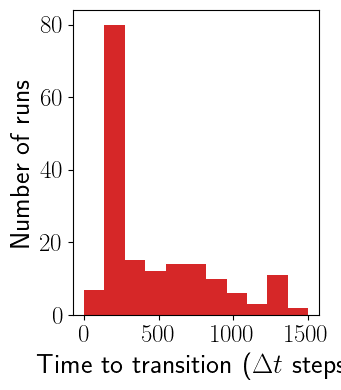

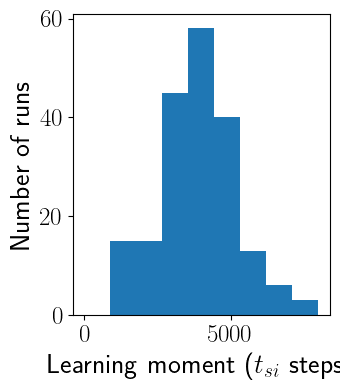

In [32]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize=(3.5,4)) 
axis.hist(1/Lsig_params[:,3], bins = np.linspace(0,1500,12),color='C3')
axis.tick_params(labelsize = 18)
axis.set_ylabel(r"Number of runs",fontsize = 20)
axis.set_xlabel(r"Time to transition ($\Delta t$ steps)", fontsize = 20)
axis.set_xticks([0,500,1000,1500])
#axis.set_yticks([0,10,20,30])
fig.tight_layout()
fig.savefig("./plots/sims_sig_transition.pdf")
plt.show()


plt.close("all")
fig,axis = plt.subplots(1,1,figsize=(3.5,4)) 
axis.hist(Lsig_params[:,2], bins = np.linspace(0,8000,10),color='C0')
axis.tick_params(labelsize = 18)
axis.set_ylabel(r"Number of runs",fontsize = 20)
axis.set_xlabel(r"Learning moment ($t_{si}$ steps)", fontsize = 20)
fig.tight_layout()
fig.savefig("./plots/sims_sig_moment.pdf")
plt.show()


### Lstep vs Lramp

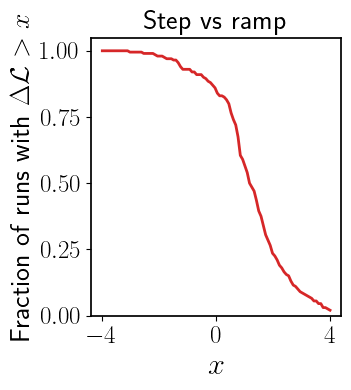

In [33]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize=(3.5,4))
xs = np.linspace(-4,4,100)
ps = []
for i,x in enumerate(xs):
    ps += [np.mean(Lsteps - Lramps > x)]
    
axis.plot(xs,ps,"C3-",lw=2)
axis.tick_params(labelsize = 18)
axis.set_ylabel(r"Fraction of runs with $\Delta \mathcal{L} > x$",fontsize = 20)
axis.set_xlabel(r"$x$", fontsize = 22)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.25)
axis.set_title("Step vs ramp",fontsize = 20)
axis.set_ylim(0,1.05)
axis.set_xticks([-4,0,4])
fig.tight_layout()
fig.savefig("./plots/sims_step_vs_ramp.pdf")
plt.show()

In [34]:
print(np.mean(Lsteps-Lramps))
print(np.mean(Lsteps-Lramps)/np.sqrt(len(Lsteps)))
print(np.mean(Lsteps > Lramps -1))

1.2163203518615198
0.08600683688964882
0.93
